# Early Detection of Malnutrition Risk in Children Under Five  
## Data Cleaning Documentation  

### Project Overview  
Malnutrition remains a critical public health issue, particularly in Sub-Saharan Africa, where food insecurity and limited healthcare access are prevalent. This project aims to leverage community-based data to identify children under five at risk of malnutrition, enabling early intervention.  

This notebook documents the data cleaning process, ensuring the dataset is reliable for analysis and model building.  


## Dataset Overview  
This dataset contains key indicators related to malnutrition risk in children under five. The variables include child growth metrics, household socioeconomic factors, and access to essential resources.  

### **Key Features:**  
- **Gender**: Sex of the child (Male/Female)  
- **Birth Order**: Position of the child in the family (e.g., firstborn, second-born)  
- **Weight-for-Age**: Standardized weight measurement based on age  
- **Height-for-Age**: Standardized height measurement based on age  
- **Weight-for-Height**: Standardized weight measurement based on height  
- **Family Size**: Total number of household members  
- **Parental Education**: Educational attainment of parents  
- **Household Income (₦)**: Monthly income of the household in Nigerian Naira  
- **Frequency of Meals**: Number of meals consumed per day  
- **Dietary Diversity**: Variety of food groups consumed  
- **Breastfeeding Duration (months)**: Duration of exclusive breastfeeding in months  
- **Access to Healthcare**: Availability of healthcare services for the child (Yes/No)  
- **Clean Water**: Access to safe drinking water (Yes/No)  
- **Sanitation Facilities**: Quality of sanitation infrastructure (Low/Medium/High)  
- **Availability of Food**: Food security status of the household (Adequate/Inadequate)  
- **Seasonal Variations**: Impact of seasonal changes on food availability (Yes/No)  
- **Market Access**: Proximity to food markets (Easy/Moderate/Difficult)  
- **Rural Location**: Whether the household is in a rural area (Yes/No)  
- **Malnutrition Risk**: Categorized risk level of malnutrition (Low/Moderate/High)  


       We import the necessary libraries for data cleaning and manipulation 
       Next, we load the data and check its structure before proceeding to cleaning. 


In [1]:
#importing pandas and other libraries to use in this project
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score


In [2]:
#loading the csv file into a pandas dataframe named df
df = pd.read_csv('malnutrition_risk-2.csv')

In [3]:
#checking the number of rows and columns in the dataset
df.shape

(235957, 20)


The dataset consists of **235957 rows and 20 columns**

## Dataset Structure and Data Types  

Before cleaning, we check the overall structure of the dataset using `df.info()`. This provides:  
- The number of **non-null values** per column.  
- The **data type** of each feature.  
- Memory usage insights.



In [4]:
#check dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235957 entries, 0 to 235956
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Age                              235957 non-null  int64  
 1   Gender                           235957 non-null  object 
 2   Birth Order                      235957 non-null  int64  
 3   Weight-for-Age                   235957 non-null  float64
 4   Height-for-Age                   235957 non-null  float64
 5   Weight-for-Height                235957 non-null  float64
 6   Family Size                      235957 non-null  int64  
 7   Parental Education               199657 non-null  object 
 8   Household Income (₦)             235957 non-null  int64  
 9   Frequency of Meals               235957 non-null  int64  
 10  Dietary Diversity                235957 non-null  int64  
 11  Breastfeeding Duration (months)  235957 non-null  int64  
 12  Ac




## **Step 2: Checking for Duplicate Records**  

### Checking for Duplicates  

Duplicate records can cause data redundancy and affect model accuracy. We check for duplicate rows and remove them if necessary.  



In [5]:
duplicates =df.duplicated().sum()
if duplicates == 0:
    print("There are no duplicates in the dataset")
else:
    print(f"There are {duplicates} duplicates in the dataset")
    


There are no duplicates in the dataset




#### **Step 3: Checking for Missing Values**  

## Checking for Missing Values  

Missing values can impact data quality and model performance. We identify columns with missing values to decide on appropriate handling techniques .  




In [6]:

# Check for missing values
df.isnull().sum()


Age                                    0
Gender                                 0
Birth Order                            0
Weight-for-Age                         0
Height-for-Age                         0
Weight-for-Height                      0
Family Size                            0
Parental Education                 36300
Household Income (₦)                   0
Frequency of Meals                     0
Dietary Diversity                      0
Breastfeeding Duration (months)        0
Access to Healthcare                   0
Clean Water                            0
Sanitation Facilities                  0
Availability of Food                   0
Seasonal Variations                    0
Market Access                          0
Rural Location                         0
Malnutrition Risk                      0
dtype: int64

### Handling Missing Values in Parental Education  

The **Parental Education** column is the only feature with missing values. To determine the best imputation strategy, we will analyze its relationship with **Malnutrition Risk** (our target variable) using a **Chi-Square test**. This will help us assess whether the missing values are random or if they have a significant association with malnutrition outcomes.  


In [7]:

import scipy.stats as stats

# Create a contingency table
contingency_table = pd.crosstab(df['Parental Education'], df['Malnutrition Risk'])

# Perform the Chi-Square test
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print results
print("Contingency Table:\n", contingency_table)
print(f"\nChi-Square Statistic: {chi2:.4f}")
print(f"P-Value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")

#  interpretation based on p values
if p_value < 0.05:
    print("\n There is a significant relationship between Parental Education and Malnutrition Risk.")
else:
    print("\n There is no significant relationship between Parental Education and Malnutrition Risk.")

Contingency Table:
 Malnutrition Risk    High    Low  Moderate
Parental Education                        
Primary             25096  28397     23750
Secondary           15846  37687     31358
Tertiary             3160  18834     15529

Chi-Square Statistic: 9507.0881
P-Value: 0.0000
Degrees of Freedom: 4

 There is a significant relationship between Parental Education and Malnutrition Risk.


### Handling Missing Values in Parental Education  

Our analysis shows a significant relationship between **Parental Education** and **Malnutrition Risk**. Given this association, we will carefully assess the proportion of missing values. If the proportion is low, we may consider removing rows with missing values to avoid introducing bias. Since imputation could distort this relationship, we will evaluate whether removal is a more appropriate approach.  


In [8]:
#PE means Parental Education
missing_values_in_PE= df['Parental Education'].isna().sum()
total_values =235957
percent_of_missing_values = (missing_values_in_PE/total_values)*100
percent_of_missing_values= round(percent_of_missing_values,2)
print(f"The percentage of missing values in the Parental Education column is {percent_of_missing_values}%")

The percentage of missing values in the Parental Education column is 15.38%


### Handling Missing Values in Parental Education  

Our analysis shows that **15.38%** of the values in the **Parental Education** column are missing. Since **Parental Education** has a significant relationship with **Malnutrition Risk**, imputing these values could introduce bias and misrepresent the true patterns in the data.  

Given that the missing values account for only **15%** of the dataset, removing these rows will not significantly impact the overall data distribution or reduce the dataset’s representativeness. Therefore, we opt to **drop rows with missing values** to maintain data integrity.  




In [9]:

# Remove rows with missing values in Parental Education
df = df.dropna(subset=['Parental Education'])

# Verify the change
df.isnull().sum()


Age                                0
Gender                             0
Birth Order                        0
Weight-for-Age                     0
Height-for-Age                     0
Weight-for-Height                  0
Family Size                        0
Parental Education                 0
Household Income (₦)               0
Frequency of Meals                 0
Dietary Diversity                  0
Breastfeeding Duration (months)    0
Access to Healthcare               0
Clean Water                        0
Sanitation Facilities              0
Availability of Food               0
Seasonal Variations                0
Market Access                      0
Rural Location                     0
Malnutrition Risk                  0
dtype: int64


### Checking and Correcting Data Types  

After handling missing values, we need to ensure that each column has the correct data type. Incorrect data types can lead to errors in analysis and modeling.  

#### **Checking Data Types**  
We first inspect the current data types of all columns to identify any inconsistencies.  



In [10]:
# to check for the data types of all columns , we us df.dtypes
df.dtypes

Age                                  int64
Gender                              object
Birth Order                          int64
Weight-for-Age                     float64
Height-for-Age                     float64
Weight-for-Height                  float64
Family Size                          int64
Parental Education                  object
Household Income (₦)                 int64
Frequency of Meals                   int64
Dietary Diversity                    int64
Breastfeeding Duration (months)      int64
Access to Healthcare                 int64
Clean Water                          int64
Sanitation Facilities                int64
Availability of Food                 int64
Seasonal Variations                  int64
Market Access                        int64
Rural Location                      object
Malnutrition Risk                   object
dtype: object

In [68]:
'''Checking for inconsistencies in a single column can be laborious . 
For that reason  i want to create a function that helps to
 detect leading/trailing spaces, case inconsistencies, and mixed data types in categorical columns
 it does this by
 1.Only check categorical columns
 2.Check for leading/trailing spaces
 3.Check for case inconsistencies
 4.Check for mixed data types
 5.Store results if any issue is found'''
def check_inconsistencies(df):
    inconsistencies = {}

    for col in df.columns:
        if df[col].dtype == 'object':  
            unique_values = df[col].dropna().unique()
            
            has_spaces = any(val != val.strip() for val in unique_values if isinstance(val, str))
            
            lowercased_values = [val.lower() for val in unique_values if isinstance(val, str)]
            has_case_issue = len(set(lowercased_values)) < len(set(unique_values))

            
            has_mixed_types = df[col].apply(lambda x: isinstance(x, str)).sum() > 0 and df[col].apply(lambda x: isinstance(x, (int, float))).sum() > 0

            
            if has_spaces or has_case_issue or has_mixed_types:
                inconsistencies[col] = {
                    "leading/trailing spaces": has_spaces,
                    "case inconsistency": has_case_issue,
                    "mixed data types": has_mixed_types
                }

    return inconsistencies

# let us call the function on our dataset
issues = check_inconsistencies(df)

# Display inconsistencies  if any is found else we will display the text no inconsistency found
if issues:
    for col, problem in issues.items():
        print(f"\nColumn: {col}")
        for issue, exists in problem.items():
            if exists:
                print(f"  - {issue.replace('_', ' ').capitalize()}:  Found")
else:
    print("No inconsistencies found. ")


No inconsistencies found. 


## Exploratory Data Analysis
#### A lot of valuable insights can  be drawn from a dataset . Exploratory Data Analysis Helps uncover this insights. Let's explore the malnutrition dataset .

In [12]:
# finding summary statistics for categorical data
df.describe(include=['O']) 


,Gender,Parental Education,Rural Location,Malnutrition Risk
count,199657,199657,199657,199657
unique,2,3,7,3
top,Male,Secondary,Kisumu,Low
freq,99836,84891,28983,84918


In [13]:
pd.set_option('display.float_format','{:.3f}'.format)

In [14]:
# We want to determine factors that affect malnutrition risk
parent_education = df.groupby('Parental Education')['Malnutrition Risk'].count()
parent_education = parent_education.reset_index()
parent_education


,Parental Education,Malnutrition Risk
0,Primary,77243
1,Secondary,84891
2,Tertiary,37523


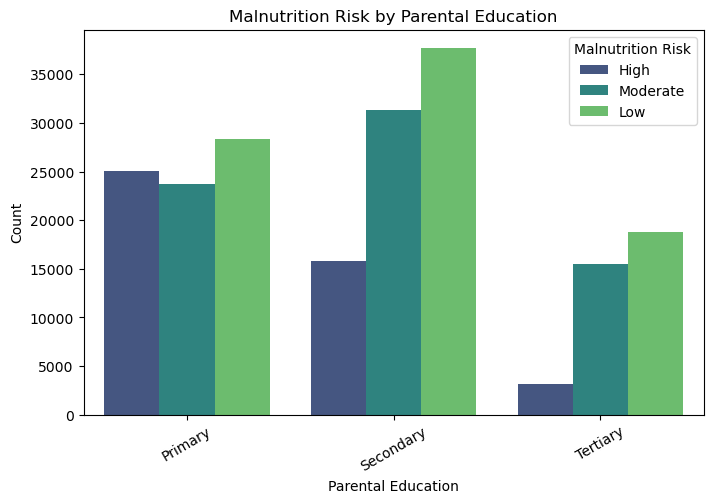

In [15]:
# visualising the countplot for parent_education

plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Parental Education', hue='Malnutrition Risk',order=['Primary','Secondary','Tertiary'],palette='viridis')
plt.xlabel("Parental Education")
plt.ylabel("Count")
plt.title("Malnutrition Risk by Parental Education")
plt.legend(title="Malnutrition Risk")
plt.xticks(rotation=30)
plt.show()

In [16]:
''' From the visualisation above we realise the least group of people to 
have high malnutrition risk are those who parents have tertiary education
followed by secondary education and primary  education. 
Increasing awareness through public education can help mitigate malnutrition even in household'''

' From the visualisation above we realise the least group of people to \nhave high malnutrition risk are those who parents have tertiary education\nfollowed by secondary education and primary  education. \nIncreasing awareness through public education can help mitigate malnutrition even in household'

In [17]:
# finding how access to clean water affect risk of malnutrition
df.groupby('Malnutrition Risk')['Clean Water'].value_counts()

Malnutrition Risk  Clean Water
High               0              26471
                   1              17631
Low                1              76285
                   0               8633
Moderate           1              63604
                   0               7033
Name: count, dtype: int64

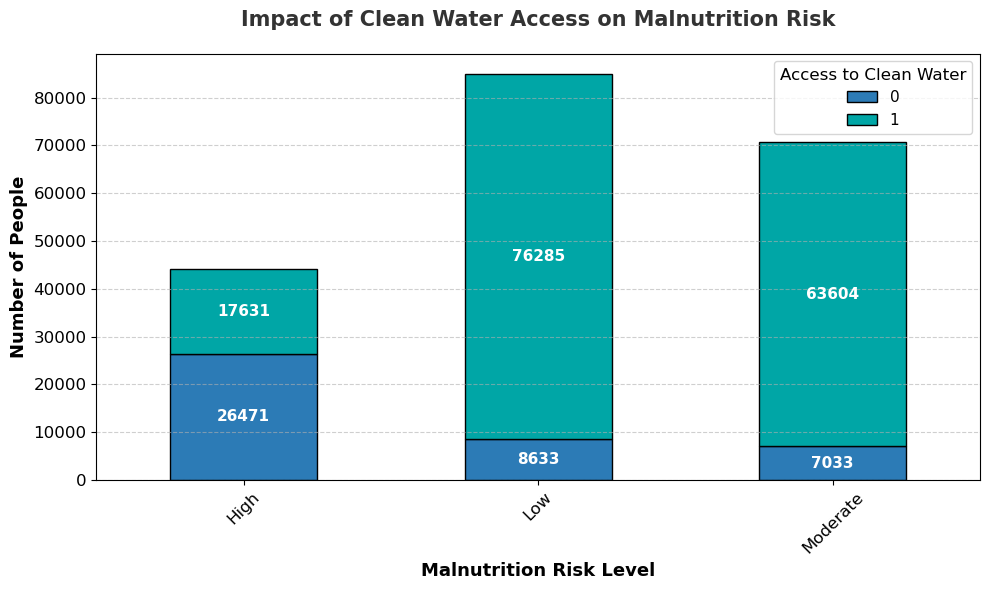

In [18]:
'''We want to plot a stacked bar chart that will visualise impact of clean water access on malnutrition risk
   We first of all  group malnutrition risk and then find the '''
water_vs_malnutrition = df.groupby('Malnutrition Risk')['Clean Water'].value_counts().unstack()

colors = ['#2C7BB6', '#00A6A6', '#73C476', '#FED976', '#FFA500']
fig, ax = plt.subplots(figsize=(10, 6))
water_vs_malnutrition.plot(kind='bar', stacked=True, color=colors, edgecolor='black', ax=ax)

ax.set_xlabel("Malnutrition Risk Level", fontsize=13, fontweight='bold')
ax.set_ylabel("Number of People", fontsize=13, fontweight='bold')
ax.set_title("Impact of Clean Water Access on Malnutrition Risk", fontsize=15, fontweight='bold', pad=20, color='#333333')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(title="Access to Clean Water", fontsize=11, title_fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.6)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='center', fontsize=11, color='white', weight='bold')

plt.tight_layout()
plt.show()


In [19]:
df.groupby('Malnutrition Risk')['Availability of Food'].value_counts()

Malnutrition Risk  Availability of Food
High               0                       30865
                   1                       13237
Low                1                       67982
                   0                       16936
Moderate           1                       56649
                   0                       13988
Name: count, dtype: int64

In [20]:
df['Availability of Food'].value_counts()

Availability of Food
1    137868
0     61789
Name: count, dtype: int64

In [21]:
df['Seasonal Variations'].value_counts()

Seasonal Variations
0    126354
1     73303
Name: count, dtype: int64

<Axes: title={'center': 'Countplot of Seasonal Variation'}, xlabel='Seasonal Variations', ylabel='count'>

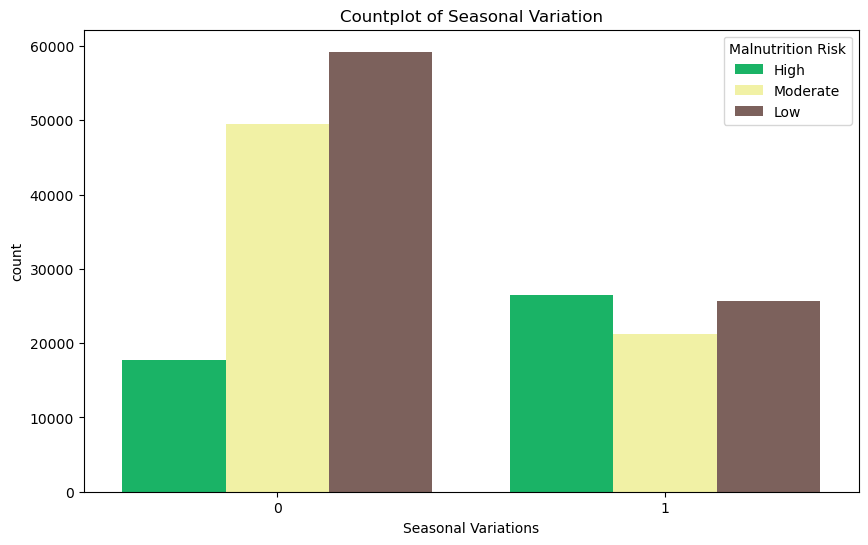

In [22]:
plt.figure(figsize=(10,6))
plt.title('Countplot of Seasonal Variation')
sns.countplot(data=df,x='Seasonal Variations',hue='Malnutrition Risk',palette='terrain' )

In [23]:
''' from the visual above, we realise when there is variation in season, there is an increase in high malnutrition  risk

suggesting that food availability, dietary diversity, and other related factors may be significantly impacted by seasonal shifts
let us investigate whether seasonal variation impacts availability of food'''


' from the visual above, we realise when there is variation in season, there is an increase in high malnutrition  risk\n\nsuggesting that food availability, dietary diversity, and other related factors may be significantly impacted by seasonal shifts\nlet us investigate whether seasonal variation impacts availability of food'

In [24]:
df.groupby('Seasonal Variations')['Availability of Food'].value_counts()

Seasonal Variations  Availability of Food
0                    1                       92483
                     0                       33871
1                    1                       45385
                     0                       27918
Name: count, dtype: int64

In [25]:
#sv_and_aovf means seasonl Variation and availability of food 
sv_and_avof = df.groupby('Seasonal Variations')['Availability of Food'].value_counts().unstack()
labels_for_pie_chart= ['Not Available', 'Available']
colors = ['#FFD700', '#1E90FF']



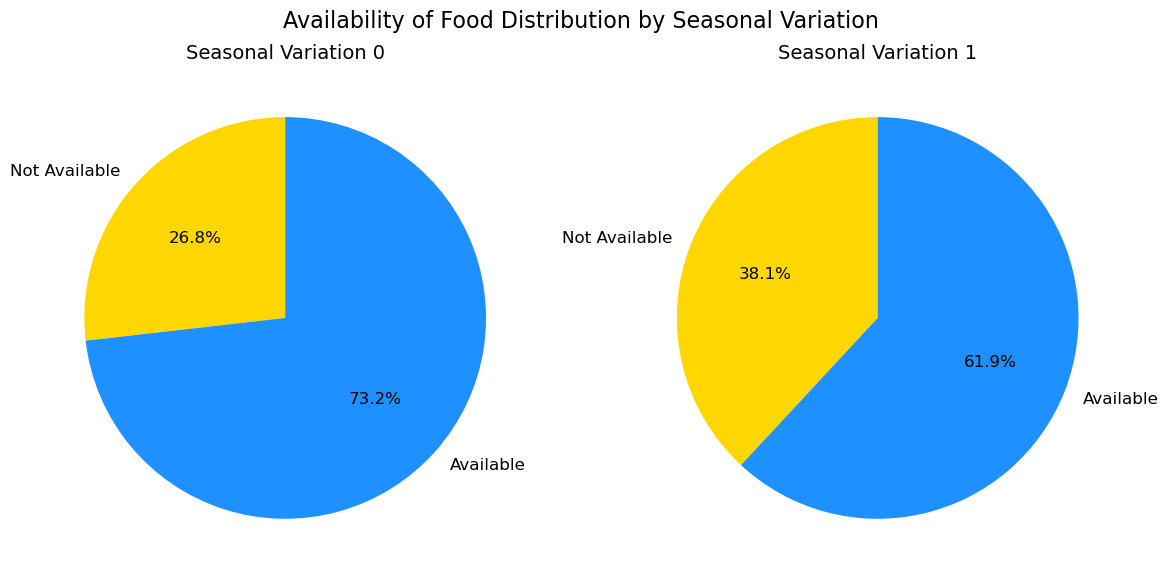

In [26]:
fig, axes = plt.subplots(1, len(sv_and_avof), figsize=(12, 6))
for i, seasonal_var in enumerate(sv_and_avof.index):
    axes[i].pie(sv_and_avof.loc[seasonal_var], labels=labels_for_pie_chart, 
                autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 12})
    axes[i].set_title(f'Seasonal Variation {seasonal_var}', fontsize=14)
plt.suptitle('Availability of Food Distribution by Seasonal Variation', fontsize=16)
plt.tight_layout()
plt.show()


In [27]:
'''from this visualisation, we realise food availability decreases when there is a change in season
 which in turn increases the risk of malnutrition'''

'from this visualisation, we realise food availability decreases when there is a change in season\n which in turn increases the risk of malnutrition'

In [28]:
df['Rural Location'].unique()

array(['Kisumu', 'Narok', 'Kakamega', 'Siaya', 'Bungoma', 'Homa Bay',
       'Migori'], dtype=object)

Text(0.5, 1.0, 'Malnutrition Risk at Various Rural Locations')

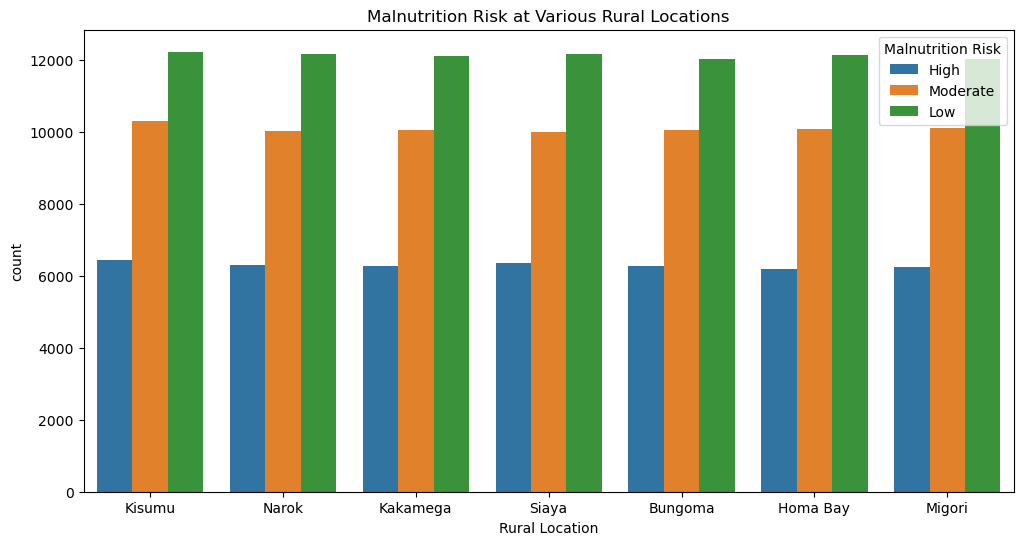

In [29]:
'''plotting a countplot to see malnutrition risk at rural areas 
   this will help us strategise where to focus more on'''
plt.figure(figsize=(12,6))
sns.countplot(data=df,x='Rural Location',hue='Malnutrition Risk',palette=['#1f77b4', '#ff7f0e', '#2ca02c'],dodge=True)
plt.title('Malnutrition Risk at Various Rural Locations')

In [30]:
'''from the visualisation above, all rural areas need equal attention in terms of offering solution '''

'from the visualisation above, all rural areas need equal attention in terms of offering solution '

In [31]:
df['Access to Healthcare'].value_counts()

Access to Healthcare
1    137520
0     62137
Name: count, dtype: int64

In [32]:
df.groupby('Access to Healthcare')['Malnutrition Risk'].value_counts()

Access to Healthcare  Malnutrition Risk
0                     High                 30916
                      Low                  17004
                      Moderate             14217
1                     Low                  67914
                      Moderate             56420
                      High                 13186
Name: count, dtype: int64

In [33]:
#HC means HealthCare
access_to_HC =df.groupby('Access to Healthcare')['Malnutrition Risk'].value_counts().unstack()

In [34]:
access_to_HC

Malnutrition Risk,High,Low,Moderate
Access to Healthcare,,,
0,30916,17004,14217
1,13186,67914,56420


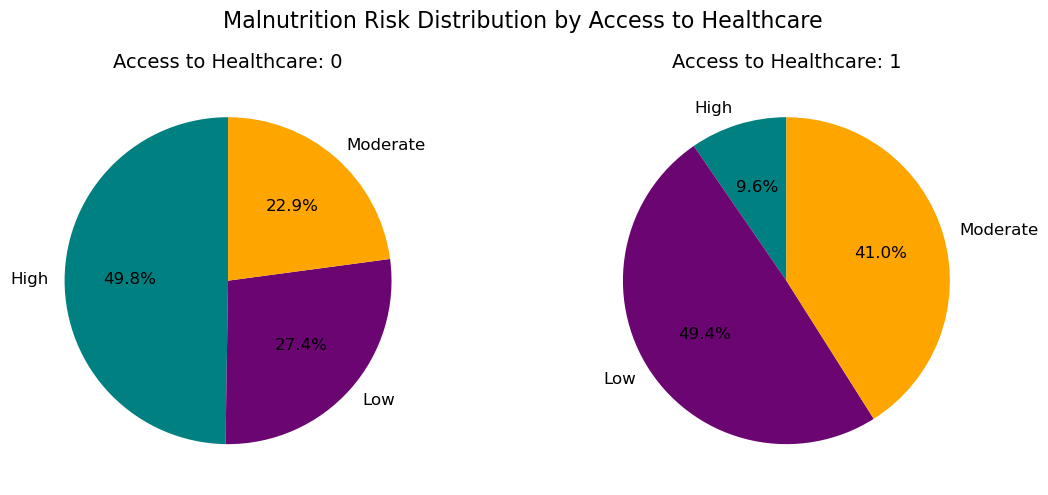

In [35]:

colors = ['#008080', '#6A0572', '#FFA500']  
labels = access_to_HC.columns.tolist()  
fig, axes = plt.subplots(1, len(access_to_HC), figsize=(12, 5))
for i, hc_status in enumerate(access_to_HC.index):
    axes[i].pie(access_to_HC.loc[hc_status], labels=labels, 
                autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 12})
    axes[i].set_title(f'Access to Healthcare: {hc_status}', fontsize=14)
plt.suptitle('Malnutrition Risk Distribution by Access to Healthcare', fontsize=16)
plt.tight_layout()
plt.show()


In [36]:
'''Areas with no  access to health care have a higher risk to malnutrition, however areas with access to 
healthcare have a lower risk to malnutrition'''

'Areas with no  access to health care have a higher risk to malnutrition, however areas with access to \nhealthcare have a lower risk to malnutrition'

In [37]:
#HC means HealthCare
access_to_market =df.groupby('Market Access')['Malnutrition Risk'].value_counts().unstack()
access_to_market

Malnutrition Risk,High,Low,Moderate
Market Access,,,
0,26453,12605,10585
1,17649,72313,60052


In [38]:
#HC means HealthCare
access_to_water =df.groupby('Clean Water')['Malnutrition Risk'].value_counts().unstack()
access_to_water

Malnutrition Risk,High,Low,Moderate
Clean Water,,,
0,26471,8633,7033
1,17631,76285,63604


In [39]:
bf=df.groupby('Sanitation Facilities')['Malnutrition Risk'].value_counts().unstack()
bf

Malnutrition Risk,High,Low,Moderate
Sanitation Facilities,,,
0,26433,12838,10565
1,17669,72080,60072


<Axes: xlabel='Household Income (₦)', ylabel='Count'>

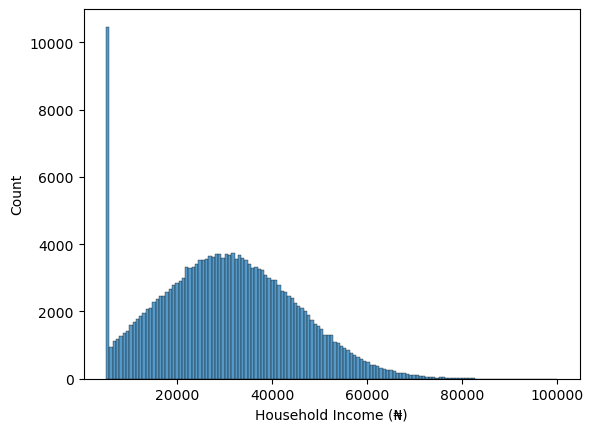

In [40]:
#visualising the house hold income column to check for normality
sns.histplot(data=df['Household Income (₦)'])

In [41]:
pd.set_option('display.float_format','{:.6f}'.format)

In [42]:
'''checking for variance in all columns , we will also check skewness
to see if it is necessary to aply log transformation'''
print(df.var(numeric_only=True))

Age                                       1.918570
Birth Order                               1.150442
Weight-for-Age                            1.607414
Height-for-Age                            1.609721
Weight-for-Height                         0.853067
Family Size                               3.430892
Household Income (₦)              207372201.568986
Frequency of Meals                        6.323138
Dietary Diversity                         6.323138
Breastfeeding Duration (months)          33.258437
Access to Healthcare                      0.214363
Clean Water                               0.166507
Sanitation Facilities                     0.187305
Availability of Food                      0.213702
Seasonal Variations                       0.232351
Market Access                             0.186820
dtype: float64


In [43]:
#checking for skewness
df.select_dtypes(include=['number']).skew()

Age                                0.629930
Birth Order                        0.866628
Weight-for-Age                    -0.289527
Height-for-Age                    -0.284068
Weight-for-Height                 -0.223825
Family Size                        0.411301
Household Income (₦)               0.223853
Frequency of Meals                 0.347159
Dietary Diversity                  0.347159
Breastfeeding Duration (months)    0.040083
Access to Healthcare              -0.815490
Clean Water                       -1.416268
Sanitation Facilities             -1.157125
Availability of Food              -0.824291
Seasonal Variations                0.551241
Market Access                     -1.163099
dtype: float64

In [44]:
''' although variance of house hold income is very high, its skewness is 0.224
 therefore applying log transformation to the column will not make any significant change'''

' although variance of house hold income is very high, its skewness is 0.224\n therefore applying log transformation to the column will not make any significant change'

<Axes: ylabel='Household Income (₦)'>

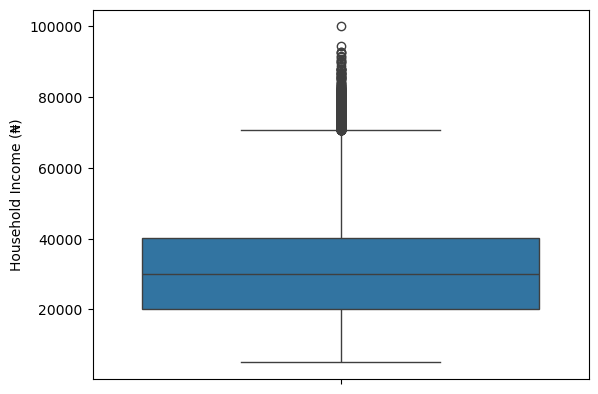

In [45]:
#checking for outlier  in Household income
sns.boxplot(data=df['Household Income (₦)'])

In [46]:
''' Outliers introduce noise to our dataset
which leads to inaccuracy in our model
to build a robust  model, we will remove outliers.
there are several methods for handling outliers but we will use 
Interquartile range (IQR)
'''

' Outliers introduce noise to our dataset\nwhich leads to inaccuracy in our model\nto build a robust  model, we will remove outliers.\nthere are several methods for handling outliers but we will use \nInterquartile range (IQR)\n'

In [47]:

Q1  = df['Household Income (₦)'].quantile(0.25)
Q3  = df['Household Income (₦)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

filtered_df = df[(df['Household Income (₦)']>=lower_bound)&(df['Household Income (₦)']<=upper_bound)]

In [48]:
filtered_df.head()

,Age,Gender,Birth Order,Weight-for-Age,Height-for-Age,Weight-for-Height,Family Size,Parental Education,Household Income (₦),Frequency of Meals,Dietary Diversity,Breastfeeding Duration (months),Access to Healthcare,Clean Water,Sanitation Facilities,Availability of Food,Seasonal Variations,Market Access,Rural Location,Malnutrition Risk
0,0,Female,1,-3.248202,-3.114656,-1.537755,7,Primary,57966,6,6,21,0,1,1,0,0,0,Kisumu,High
1,0,Male,2,-2.070860,-1.380585,-1.399325,9,Tertiary,20834,4,4,11,1,1,1,1,0,1,Narok,Moderate
2,3,Male,1,-1.105947,-0.567713,0.217038,6,Secondary,32686,5,5,11,1,1,1,1,0,1,Narok,Low
5,0,Female,2,0.144950,-0.207213,-0.617404,6,Primary,31466,10,10,21,1,1,1,1,0,1,Kakamega,Low
6,0,Male,1,-1.912502,-0.914850,-0.284324,9,Secondary,39248,5,5,9,1,1,1,1,0,1,Siaya,Moderate


<Axes: xlabel='Household Income (₦)'>

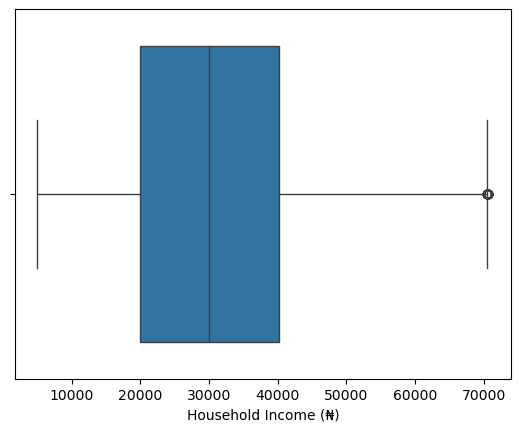

In [49]:
#visualising data after removal of outliers
sns.boxplot(data=filtered_df,x='Household Income (₦)')

<Axes: xlabel='Family Size'>

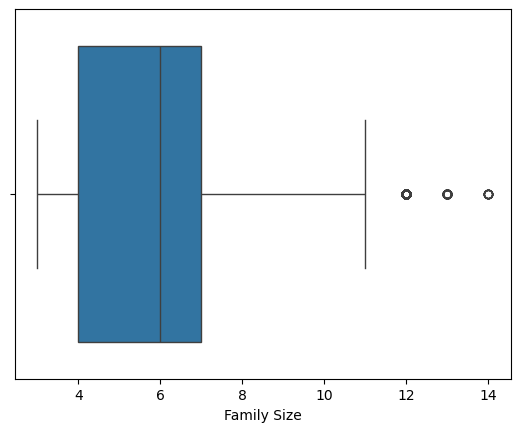

In [50]:
sns.boxplot(data=filtered_df,x='Family Size')

<Axes: xlabel='Family Size'>

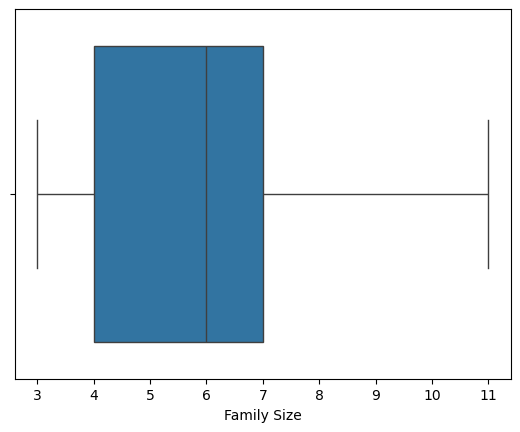

In [51]:
q1 = df['Family Size'].quantile(0.25)
q3 = df['Family Size'].quantile(0.75)
iqr = q3-q1

Lower_Bound = q1 - 1.5*iqr
Upper_Bound = q3 + 1.5*iqr

new_filtered_df = filtered_df[(filtered_df['Family Size']>=Lower_Bound)&(filtered_df['Family Size']<=Upper_Bound) ]
sns.boxplot(data=new_filtered_df,x='Family Size')

In [52]:

df = new_filtered_df.reset_index(drop = True)

<Axes: xlabel='Weight-for-Height'>

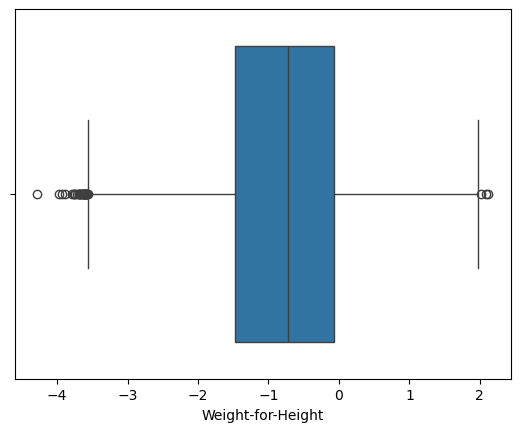

In [53]:
sns.boxplot(data=df,x='Weight-for-Height')

In [54]:
first_q = df['Weight-for-Height'].quantile(0.25)
third_q = df['Weight-for-Height'].quantile(0.75)
inter_q_r = third_q -first_q

Lower_Bound = first_q - 1.5*inter_q_r
Upper_Bound = third_q + 1.5*inter_q_r


df = df[(df['Weight-for-Height']>=Lower_Bound)&(df['Weight-for-Height']<=Upper_Bound) ]

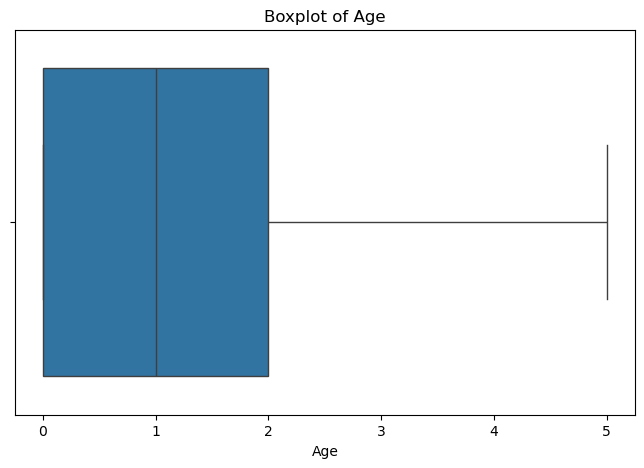

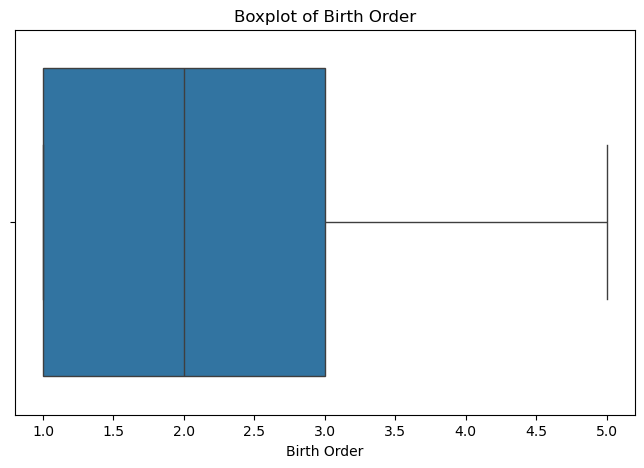

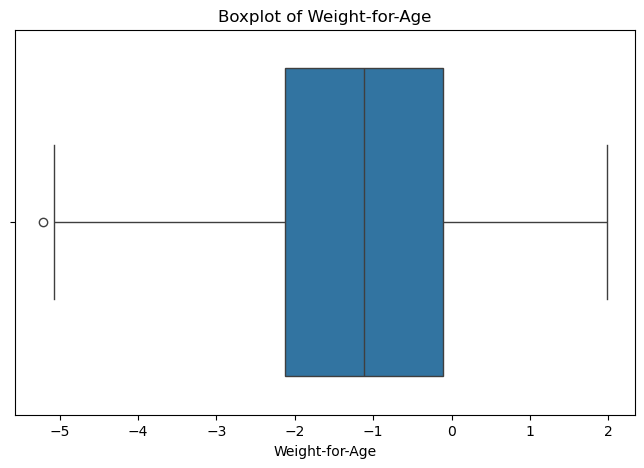

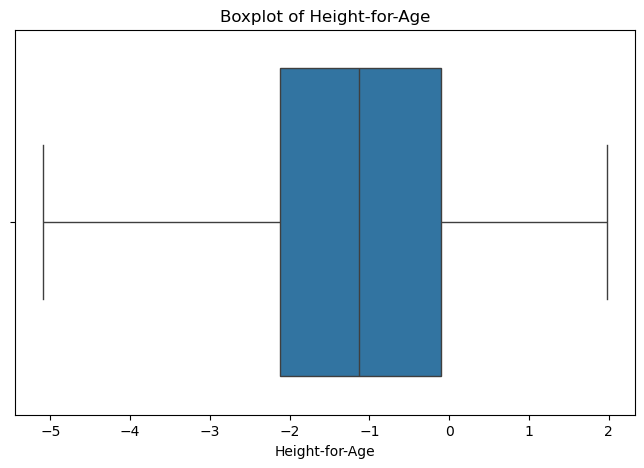

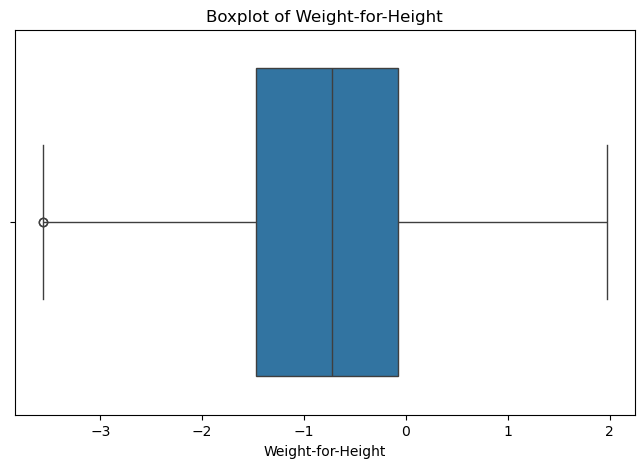

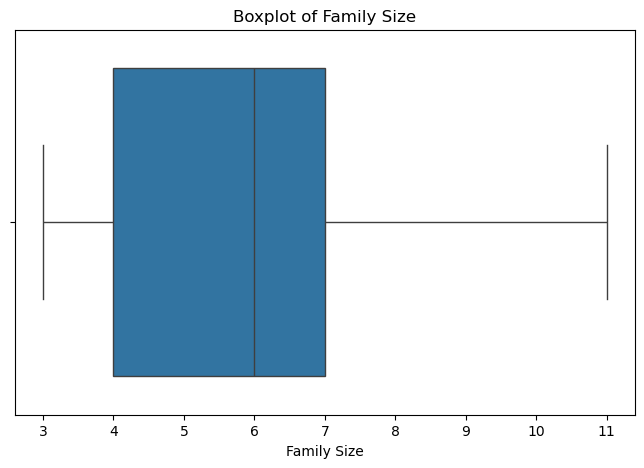

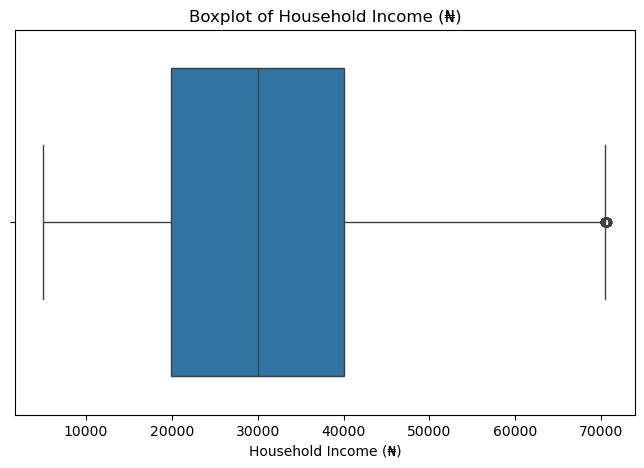

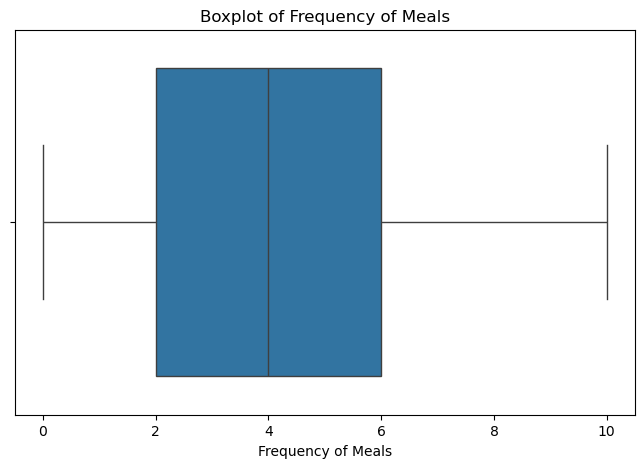

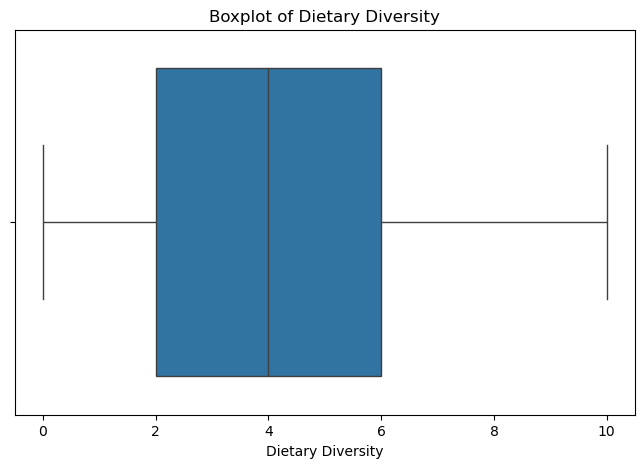

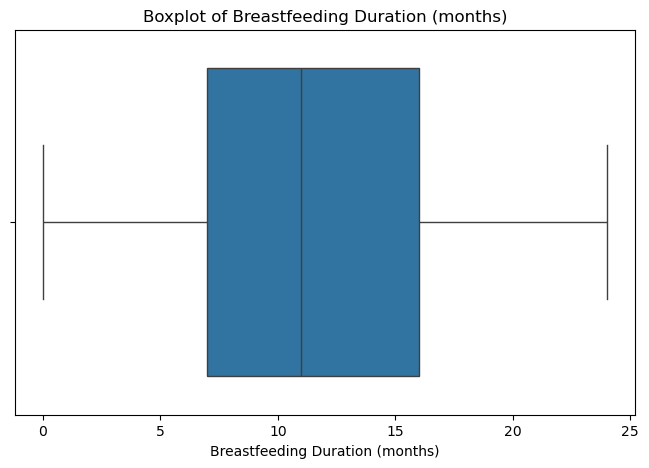

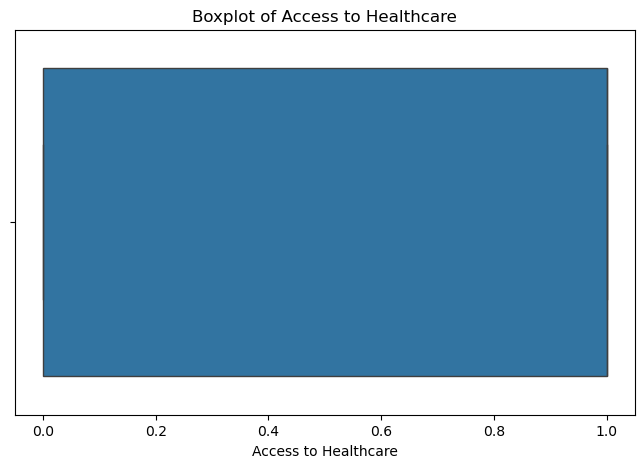

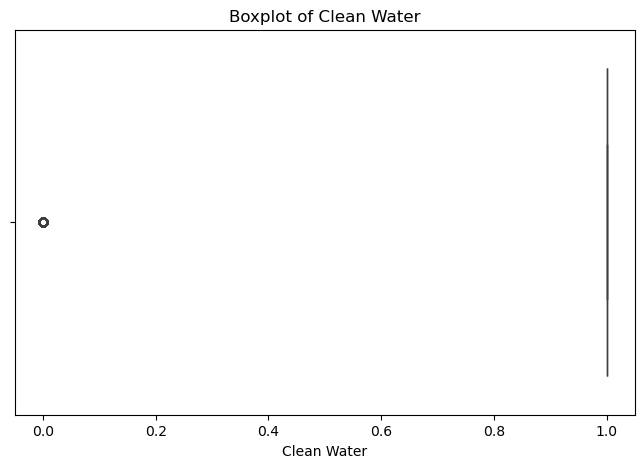

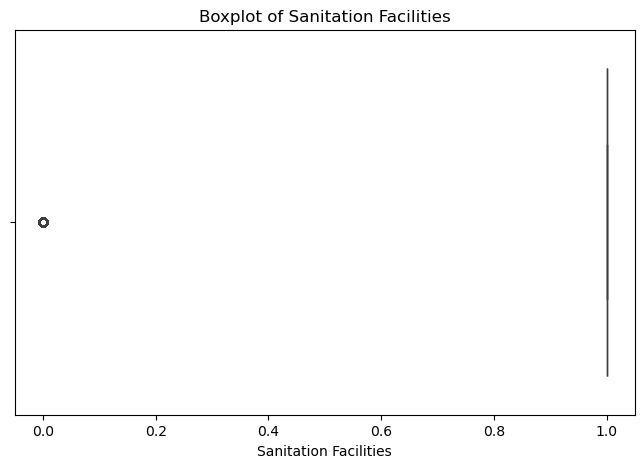

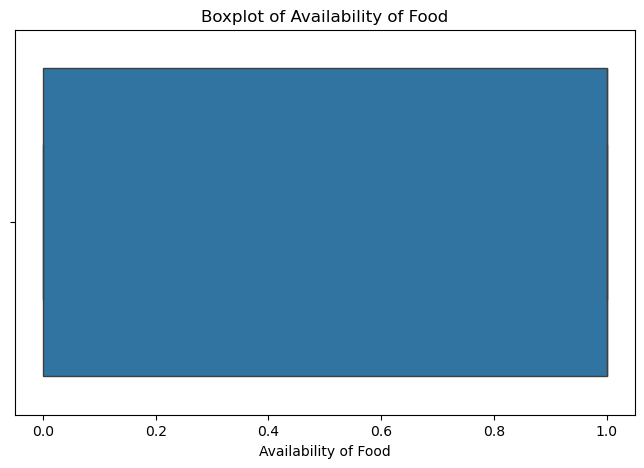

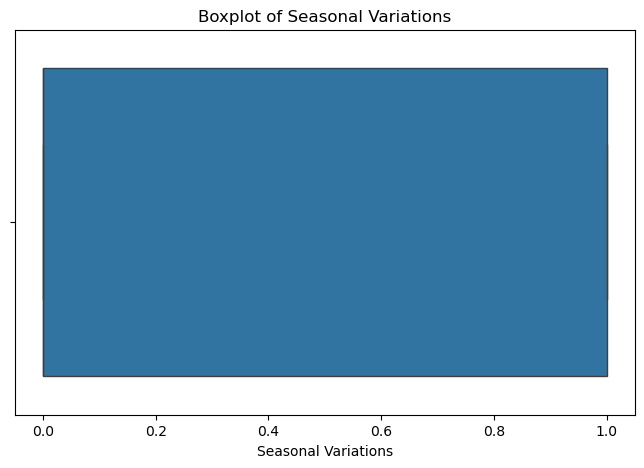

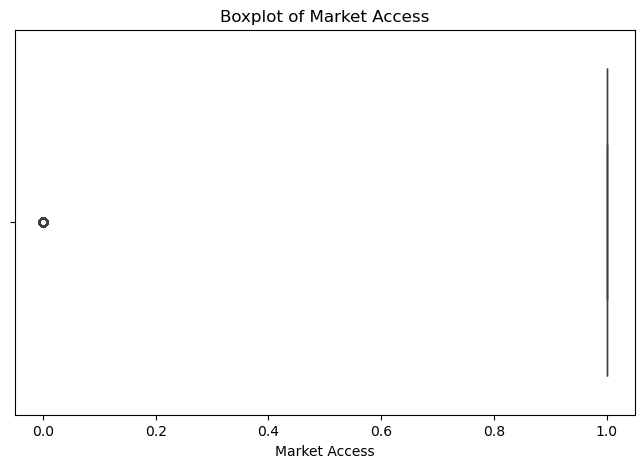

In [55]:

numeric_cols = df.select_dtypes(include=['number'])

# Create boxplots for each numeric column
for column in numeric_cols.columns:
    plt.figure(figsize=(8, 5))  
    sns.boxplot(data=df, x=column)
    plt.title(f'Boxplot of {column}')
    plt.show()  


In [69]:
'''We have already imported label encoder so we transform the  categorical
columns that will be needful in our model
we do not include rural location because it has no specific rank
applying label encoder to transform our dataset will lead to inaccurate results
we therefore apply  one hot encoding to that column'''

'We have already imported label encoder so we transform the  categorical\ncolumns that will be needful in our model\nwe do not include rural location because it has no specific rank\napplying label encoder to transform our dataset will lead to inaccurate results\nwe therefore apply  one hot encoding to that column'

In [56]:

le = LabelEncoder()

df['Parental Education'] = le.fit_transform(df['Parental Education'])
df['Malnutrition Risk'] = le.fit_transform(df['Malnutrition Risk'])




In [57]:
print(df['Rural Location'].unique())


['Kisumu' 'Narok' 'Kakamega' 'Siaya' 'Bungoma' 'Homa Bay' 'Migori']


In [58]:
df

,Age,Gender,Birth Order,Weight-for-Age,Height-for-Age,Weight-for-Height,Family Size,Parental Education,Household Income (₦),Frequency of Meals,Dietary Diversity,Breastfeeding Duration (months),Access to Healthcare,Clean Water,Sanitation Facilities,Availability of Food,Seasonal Variations,Market Access,Rural Location,Malnutrition Risk
0,0,Female,1,-3.248202,-3.114656,-1.537755,7,0,57966,6,6,21,0,1,1,0,0,0,Kisumu,0
1,0,Male,2,-2.070860,-1.380585,-1.399325,9,2,20834,4,4,11,1,1,1,1,0,1,Narok,2
2,3,Male,1,-1.105947,-0.567713,0.217038,6,1,32686,5,5,11,1,1,1,1,0,1,Narok,1
3,0,Female,2,0.144950,-0.207213,-0.617404,6,0,31466,10,10,21,1,1,1,1,0,1,Kakamega,1
4,0,Male,1,-1.912502,-0.914850,-0.284324,9,1,39248,5,5,9,1,1,1,1,0,1,Siaya,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198672,1,Female,4,-1.535730,-2.325087,-0.343884,4,1,59226,3,3,9,1,0,1,0,1,1,Migori,2
198673,0,Male,2,-1.152274,-0.779167,-1.562159,7,1,13103,4,4,16,1,1,0,1,1,1,Kakamega,2
198674,0,Male,3,-1.623792,-1.147737,-0.816833,4,1,9299,3,3,14,1,1,1,1,0,1,Narok,2
198675,1,Female,1,-1.536102,-2.036423,-0.307680,10,0,46793,4,4,22,1,1,0,1,0,0,Narok,2


In [59]:


# One-hot encode 'Rural Location'
rural_loc = pd.get_dummies(df['Rural Location'], drop_first=True, prefix='Location')

# Concatenate back to the original DataFrame
df = pd.concat([df, rural_loc], axis=1)

# Drop the original 'Rural Location' column if needed
df.drop(columns=['Rural Location'], inplace=True)



In [60]:


df.head()


,Age,Gender,Birth Order,Weight-for-Age,Height-for-Age,Weight-for-Height,Family Size,Parental Education,Household Income (₦),Frequency of Meals,...,Availability of Food,Seasonal Variations,Market Access,Malnutrition Risk,Location_Homa Bay,Location_Kakamega,Location_Kisumu,Location_Migori,Location_Narok,Location_Siaya
0,0,Female,1,-3.248202,-3.114656,-1.537755,7,0,57966,6,...,0,0,0,0,False,False,True,False,False,False
1,0,Male,2,-2.070860,-1.380585,-1.399325,9,2,20834,4,...,1,0,1,2,False,False,False,False,True,False
2,3,Male,1,-1.105947,-0.567713,0.217038,6,1,32686,5,...,1,0,1,1,False,False,False,False,True,False
3,0,Female,2,0.144950,-0.207213,-0.617404,6,0,31466,10,...,1,0,1,1,False,True,False,False,False,False
4,0,Male,1,-1.912502,-0.914850,-0.284324,9,1,39248,5,...,1,0,1,2,False,False,False,False,False,True


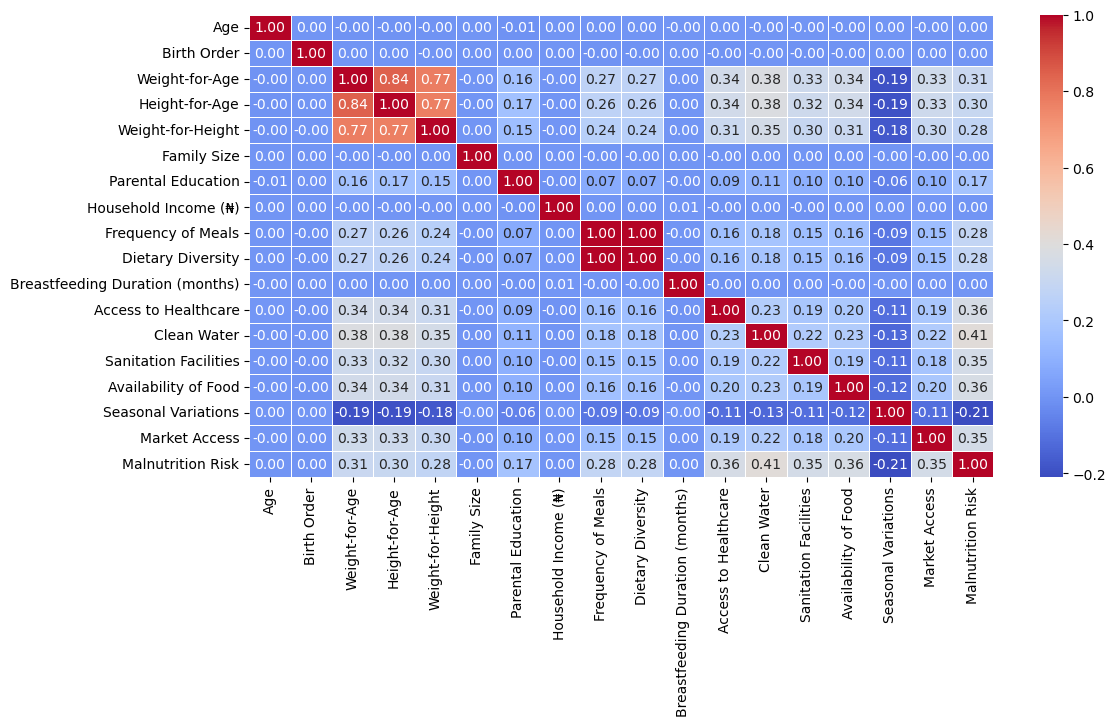

In [62]:
numeric_df = df.select_dtypes(include=['number'])  # Select only numeric columns
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12,6))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=0.5, cmap='coolwarm', fmt=".2f")
plt.show()


In [63]:
'''Looking at the correlation matrix, we can tell that Weight-for-Age,
   Height-for-Age,Weight-for-Height are have correlation amongst themselves
   hence causes multicollinearity which is not good for linear models like logistic regression.
   so we will drop Height-for-Age and Weight-for-Height
'''
X = df.drop(columns=['Height-for-Age','Age','Gender','Household Income (₦)',
                     'Breastfeeding Duration (months)','Weight-for-Height',
                     'Family Size','Malnutrition Risk'])  # This extracts actual data
y = df['Malnutrition Risk']


In [73]:
from sklearn.metrics import classification_report, accuracy_score

# Train-test split , we use stratify to maintain class proportion after splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize Logistic Regression model
log_model = LogisticRegression(multi_class='multinomial')

# Fit the model to the training data
log_model.fit(X_train, y_train)

# Make predictions on the test data
predictions = log_model.predict(X_test)

# Calculate and print the classification report
print("Classification Report:\n")
print(classification_report(y_test, predictions))

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")


/Library/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8768
           1       0.94      0.94      0.94     16906
           2       0.91      0.91      0.91     14055

    accuracy                           0.94     39729
   macro avg       0.94      0.94      0.94     39729
weighted avg       0.94      0.94      0.94     39729

Accuracy: 0.9381


/Library/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [65]:

log_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)

cv_scores = cross_val_score(log_model, X, y, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())


/Library/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was 

Cross-Validation Accuracy Scores: [0.93553827 0.93430492 0.93543759 0.93616593 0.93707209]
Mean Accuracy: 0.9357037591583908


In [66]:
#let us train our dataset with a different models and select the best model to use out of the results we get for each model
rf_model= RandomForestClassifier(n_estimators =100,random_state=42)
rf_model.fit(X_train,y_train)
rf_predict= rf_model.predict(X_test)
rf_acc = rf_model.score(X_test,y_test)
print(rf_acc)


0.931284452163407


In [67]:
#training the dataset using neural network from tensorflow,  the import statements are at the beginning of the notebook
nn_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  
])

nn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

nn_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test, y_test))

nn_acc = nn_model.evaluate(X_test, y_test, verbose=0)[1]
print(f' The accuracy of our model using a neural network is: {nn_acc:.4f}')


Epoch 1/20


/Library/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4967/4967 ━━━━━━━━━━━━━━━━━━━━ 2s 400us/step - accuracy: 0.9172 - loss: 0.2117 - val_accuracy: 0.9274 - val_loss: 0.1802
Epoch 2/20
4967/4967 ━━━━━━━━━━━━━━━━━━━━ 2s 387us/step - accuracy: 0.9331 - loss: 0.1693 - val_accuracy: 0.9338 - val_loss: 0.1692
Epoch 3/20
4967/4967 ━━━━━━━━━━━━━━━━━━━━ 2s 441us/step - accuracy: 0.9343 - loss: 0.1669 - val_accuracy: 0.9379 - val_loss: 0.1598
Epoch 4/20
4967/4967 ━━━━━━━━━━━━━━━━━━━━ 2s 403us/step - accuracy: 0.9352 - loss: 0.1640 - val_accuracy: 0.9358 - val_loss: 0.1637
Epoch 5/20
4967/4967 ━━━━━━━━━━━━━━━━━━━━ 2s 397us/step - accuracy: 0.9337 - loss: 0.1665 - val_accuracy: 0.9343 - val_loss: 0.1631
Epoch 6/20
4967/4967 ━━━━━━━━━━━━━━━━━━━━ 2s 423us/step - accuracy: 0.9350 - loss: 0.1650 - val_accuracy: 0.9373 - val_loss: 0.1617
Epoch 7/20
4967/4967 ━━━━━━━━━━━━━━━━━━━━ 2s 414us/step - accuracy: 0.9343 - loss: 0.1655 - val_accuracy: 0.9380 - val_loss: 0.1598
Epoch 8/20
4967/4967 ━━━━━━━━━━━━━━━━━━━━ 2s 403us/step - accuracy: 0.9346 - loss: 0.16

In [ ]:
#neural network is the best model so we save it 

In [70]:
import joblib

In [74]:
joblib.dump((nn_model, le), 'malnutrition_neural_network_1.0.pkl')


['malnutrition_neural_network_1.0.pkl']